# Baseline Model Training (No Augmentation)

This notebook trains a colorization model without data augmentation to establish a baseline performance.

## Objectives:
- Train U-Net model on original data only
- Establish baseline performance metrics
- Save model for comparison with augmented version
- Monitor training progress and prevent overfitting

In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import yaml
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')
from data_preprocessing import DataPreprocessor
from model_architecture import create_model, initialize_weights
from training import ColorizationTrainer, train_model
from evaluation import ColorizationEvaluator, evaluate_single_image
from utils import create_training_curves, save_experiment_config, log_gpu_usage

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    log_gpu_usage()

Libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


## 1. Setup and Configuration

In [2]:
# Load configuration
config_path = "../config/config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Baseline Training Configuration:")
print("=" * 40)
print(f"Model architecture: {config['model']['architecture']}")
print(f"Input size: {config['data']['input_size']}")
print(f"Batch size: {config['data']['batch_size']}")
print(f"Learning rate: {config['training']['learning_rate']}")
print(f"Epochs: {config['training']['epochs']}")
print(f"Loss function: {config['training']['loss_function']}")

# Setup directories
processed_dir = "../data/processed"
train_dir = os.path.join(processed_dir, "train")
val_dir = os.path.join(processed_dir, "val")
test_dir = os.path.join(processed_dir, "test")

baseline_model_dir = "../models/baseline_model"
baseline_results_dir = "../results/baseline"

# Create directories
os.makedirs(baseline_model_dir, exist_ok=True)
os.makedirs(baseline_results_dir, exist_ok=True)

print(f"\nModel will be saved to: {baseline_model_dir}")
print(f"Results will be saved to: {baseline_results_dir}")

# Check data availability
def count_images(directory):
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory) 
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

train_count = count_images(train_dir)
val_count = count_images(val_dir)
test_count = count_images(test_dir)

print(f"\nDataset Status:")
print(f"Training images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

if train_count == 0:
    print("\n❌ No training data found!")
    print("Please run notebook 02_data_preprocessing.ipynb first.")
    raise SystemExit("Training data required")

if val_count == 0:
    print("\n⚠️ No validation data found. Using training data for validation.")
    val_dir = train_dir

Baseline Training Configuration:
Model architecture: unet
Input size: [256, 256]
Batch size: 16
Learning rate: 0.001
Epochs: 100
Loss function: mse

Model will be saved to: ../models/baseline_model
Results will be saved to: ../results/baseline

Dataset Status:
Training images: 9
Validation images: 9
Test images: 9


## 2. Create Data Loaders (No Augmentation)

In [3]:
# Initialize data preprocessor
preprocessor = DataPreprocessor(config_path)

print("Creating data loaders (baseline - no augmentation)...")

try:
    # Create data loaders without augmentation
    train_loader, val_loader, test_loader = preprocessor.create_dataloaders(
        train_dir,
        val_dir,
        test_dir if test_count > 0 else None
    )
    
    print(f"✓ Data loaders created successfully!")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")
    if test_loader:
        print(f"  Test batches: {len(test_loader)}")
    
    # Test data loading
    print("\nTesting data loading...")
    for L, AB, filenames in train_loader:
        print(f"✓ Batch loaded successfully:")
        print(f"  L channel shape: {L.shape}")
        print(f"  AB channels shape: {AB.shape}")
        print(f"  Value ranges: L[{L.min():.3f}, {L.max():.3f}], AB[{AB.min():.3f}, {AB.max():.3f}]")
        break
        
except Exception as e:
    print(f"❌ Error creating data loaders: {e}")
    raise

INFO:data_preprocessing:Found 9 images in ../data/processed\train
INFO:data_preprocessing:Found 9 images in ../data/processed\val
INFO:data_preprocessing:Found 9 images in ../data/processed\test
INFO:data_preprocessing:Created data loaders:
INFO:data_preprocessing:  Train: 1 batches
INFO:data_preprocessing:  Val: 1 batches
INFO:data_preprocessing:  Test: 1 batches


Creating data loaders (baseline - no augmentation)...
✓ Data loaders created successfully!
  Train batches: 1
  Validation batches: 1
  Test batches: 1

Testing data loading...
✓ Batch loaded successfully:
  L channel shape: torch.Size([9, 1, 256, 256])
  AB channels shape: torch.Size([9, 2, 256, 256])
  Value ranges: L[-1.000, 1.000], AB[-0.549, 0.702]


## 3. Create and Initialize Model

In [4]:
# Create baseline model
print("Creating baseline model...")

try:
    model = create_model(config_path)
    
    # Initialize weights
    initialize_weights(model)
    
    # Print model information
    num_params = model.count_parameters()
    model_size = model.get_model_size()
    
    print(f"✓ Model created successfully!")
    print(f"  Architecture: {model.architecture}")
    print(f"  Parameters: {num_params:,}")
    print(f"  Model size: {model_size:.2f} MB")
    
    # Test forward pass
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    print(f"  Device: {device}")
    
    # Test with dummy input
    dummy_input = torch.randn(1, 1, *config['data']['input_size']).to(device)
    with torch.no_grad():
        dummy_output = model(dummy_input)
    
    print(f"  Test forward pass: ✓")
    print(f"  Input shape: {dummy_input.shape}")
    print(f"  Output shape: {dummy_output.shape}")
    
except Exception as e:
    print(f"❌ Error creating model: {e}")
    raise

Creating baseline model...


INFO:model_architecture:Initialized unet model
INFO:model_architecture:Model created with 31,036,546 trainable parameters
INFO:model_architecture:Model size: 118.44 MB


✓ Model created successfully!
  Architecture: unet
  Parameters: 31,036,546
  Model size: 118.44 MB
  Device: cpu
  Test forward pass: ✓
  Input shape: torch.Size([1, 1, 256, 256])
  Output shape: torch.Size([1, 2, 256, 256])


## 4. Setup Training

In [5]:
# Create trainer
print("Setting up baseline training...")

try:
    trainer = ColorizationTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        config_path=config_path
    )
    
    print("✓ Trainer initialized successfully!")
    print(f"  Device: {trainer.device}")
    print(f"  Mixed precision: {trainer.use_amp}")
    print(f"  Optimizer: {type(trainer.optimizer).__name__}")
    print(f"  Scheduler: {type(trainer.scheduler).__name__ if trainer.scheduler else 'None'}")
    print(f"  Loss function: {type(trainer.criterion).__name__}")
    
    # Log GPU usage after model creation
    if torch.cuda.is_available():
        log_gpu_usage()
    
except Exception as e:
    print(f"❌ Error setting up training: {e}")
    raise

INFO:training:Using CPU
INFO:training:Using ADAM optimizer with lr=0.001
INFO:training:Using cosine scheduler
INFO:training:Using MSE loss
INFO:training:Trainer initialized on device: cpu


Setting up baseline training...
✓ Trainer initialized successfully!
  Device: cpu
  Mixed precision: True
  Optimizer: Adam
  Scheduler: CosineAnnealingLR
  Loss function: MSELoss


## 5. Training Progress Monitoring

In [6]:
# Setup monitoring
from IPython.display import clear_output
import time

def plot_training_progress(train_losses, val_losses, title="Baseline Model Training Progress"):
    """Plot training progress in real-time."""
    if len(train_losses) == 0:
        return
    
    clear_output(wait=True)
    
    plt.figure(figsize=(12, 4))
    
    # Loss curves
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Recent loss (last 20 epochs)
    plt.subplot(1, 2, 2)
    recent_start = max(0, len(train_losses) - 20)
    recent_epochs = epochs[recent_start:]
    recent_train = train_losses[recent_start:]
    recent_val = val_losses[recent_start:]
    
    plt.plot(recent_epochs, recent_train, 'b-', label='Training Loss', linewidth=2)
    plt.plot(recent_epochs, recent_val, 'r-', label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Recent Training Progress (Last 20 Epochs)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print current status
    current_epoch = len(train_losses)
    current_train_loss = train_losses[-1]
    current_val_loss = val_losses[-1]
    best_val_loss = min(val_losses)
    
    print(f"Epoch {current_epoch}: Train Loss = {current_train_loss:.4f}, Val Loss = {current_val_loss:.4f}")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    
    if torch.cuda.is_available():
        memory_used = torch.cuda.memory_allocated() / 1024**3
        print(f"GPU Memory: {memory_used:.2f} GB")

print("Training monitoring setup complete!")

Training monitoring setup complete!


## 6. Start Baseline Training

In [7]:
# Save experiment configuration
experiment_name = f"baseline_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
save_experiment_config(config, experiment_name, baseline_results_dir)

print(f"Starting baseline model training...")
print(f"Experiment name: {experiment_name}")
print(f"Results directory: {baseline_results_dir}")
print("\n" + "="*50)
print("BASELINE TRAINING (NO AUGMENTATION)")
print("="*50)

try:
    # Start training
    start_time = time.time()
    
    # Custom training loop with progress monitoring
    num_epochs = config['training']['epochs']
    train_losses = []
    val_losses = []
    
    print(f"Training for {num_epochs} epochs...")
    
    # Option 1: Use built-in trainer (simpler)
    history = trainer.train()
    
    end_time = time.time()
    training_duration = end_time - start_time
    
    print(f"\n✅ Baseline training completed!")
    print(f"Training time: {training_duration:.2f} seconds ({training_duration/60:.1f} minutes)")
    print(f"Best validation loss: {history['best_val_loss']:.4f}")
    print(f"Final training loss: {history['train_losses'][-1]:.4f}")
    print(f"Final validation loss: {history['val_losses'][-1]:.4f}")
    
    # Save training history
    history_path = os.path.join(baseline_results_dir, 'training_history.yaml')
    with open(history_path, 'w') as f:
        yaml.dump({
            'experiment_name': experiment_name,
            'training_duration_seconds': training_duration,
            'best_val_loss': float(history['best_val_loss']),
            'final_train_loss': float(history['train_losses'][-1]),
            'final_val_loss': float(history['val_losses'][-1]),
            'total_epochs': len(history['train_losses']),
            'train_losses': [float(x) for x in history['train_losses']],
            'val_losses': [float(x) for x in history['val_losses']]
        }, f)
    
    print(f"Training history saved to: {history_path}")
    
except Exception as e:
    print(f"❌ Training failed: {e}")
    raise

INFO:utils:Experiment config saved to ../results/baseline\baseline_training_20250823_100044_config_20250823_100044.yaml
INFO:training:Starting training for 100 epochs


Starting baseline model training...
Experiment name: baseline_training_20250823_100044
Results directory: ../results/baseline

BASELINE TRAINING (NO AUGMENTATION)
Training for 100 epochs...


Validation: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.02s/it]
INFO:training:Epoch 1/100 - Train Loss: 0.9131, Val Loss: 0.4998, LR: 0.001000
INFO:training:New best model saved with validation loss: 0.4998
Validation: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.48s/it]
INFO:training:Epoch 2/100 - Train Loss: 0.8767, Val Loss: 0.9641, LR: 0.000999
Validation: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.35s/it]
INFO:training:Epoch 3/100 - Train Loss: 0.8216, Val Loss: 1.0003, LR: 0.000998
Validation: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.09s/it]
INFO:training:Epoch 4/100 - Train Loss: 0.7508, Val Loss: 1.0100, LR: 0.000996
Validation: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.89s/it]
INFO:training:Epoch 


✅ Baseline training completed!
Training time: 1075.69 seconds (17.9 minutes)
Best validation loss: 0.4998
Final training loss: 0.2483
Final validation loss: 0.7509
Training history saved to: ../results/baseline\training_history.yaml


## 7. Save Baseline Model

In [8]:
# Save the trained baseline model
if 'history' in locals():
    print("Saving baseline model...")
    
    try:
        # Save complete model state
        model_save_path = os.path.join(baseline_model_dir, 'baseline_model_complete.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_architecture': config['model']['architecture'],
            'model_config': config['model'],
            'training_config': config['training'],
            'data_config': config['data'],
            'training_history': history,
            'experiment_name': experiment_name,
            'total_parameters': model.count_parameters(),
            'model_size_mb': model.get_model_size()
        }, model_save_path)
        
        # Save just the model weights (for easy loading)
        weights_save_path = os.path.join(baseline_model_dir, 'baseline_weights.pth')
        torch.save(model.state_dict(), weights_save_path)
        
        print(f"✓ Complete model saved to: {model_save_path}")
        print(f"✓ Model weights saved to: {weights_save_path}")
        
        # Create model info file
        model_info = {
            'model_name': 'Baseline Colorization Model',
            'architecture': config['model']['architecture'],
            'input_channels': config['model']['input_channels'],
            'output_channels': config['model']['output_channels'],
            'total_parameters': model.count_parameters(),
            'model_size_mb': model.get_model_size(),
            'training_data_augmented': False,
            'best_validation_loss': float(history['best_val_loss']),
            'training_epochs': len(history['train_losses']),
            'training_duration_minutes': training_duration / 60,
            'created_date': datetime.now().isoformat(),
            'files': {
                'complete_model': 'baseline_model_complete.pth',
                'weights_only': 'baseline_weights.pth',
                'training_history': '../results/baseline/training_history.yaml'
            }
        }
        
        info_path = os.path.join(baseline_model_dir, 'model_info.yaml')
        with open(info_path, 'w') as f:
            yaml.dump(model_info, f, default_flow_style=False)
        
        print(f"✓ Model info saved to: {info_path}")
        
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        
else:
    print("No training history available - model not saved")

Saving baseline model...
✓ Complete model saved to: ../models/baseline_model\baseline_model_complete.pth
✓ Model weights saved to: ../models/baseline_model\baseline_weights.pth
✓ Model info saved to: ../models/baseline_model\model_info.yaml


## 8. Generate Training Curves

Generating training curves...


INFO:utils:Training curves saved to ../results/baseline\training_curves.png


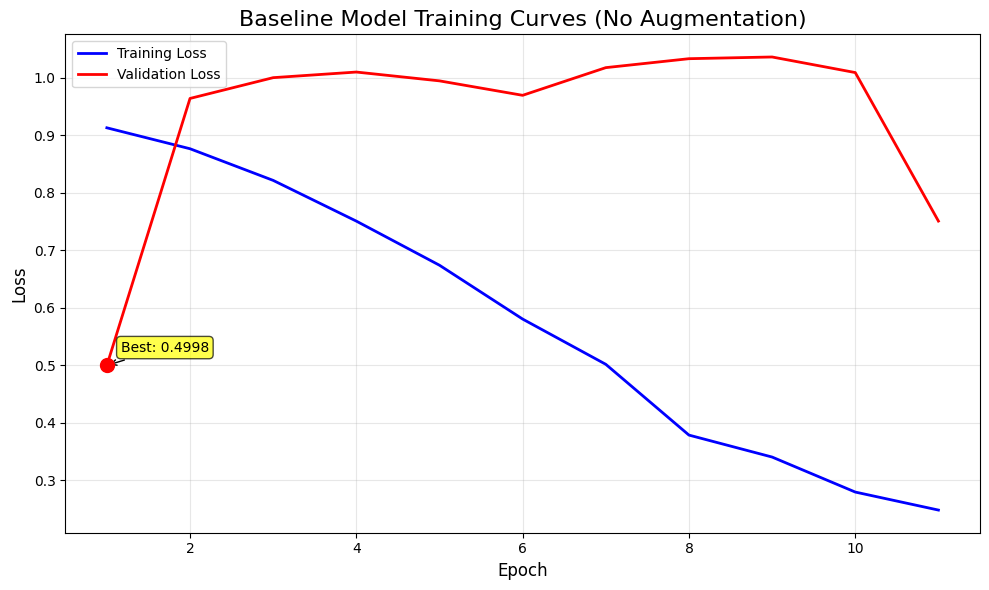

✓ Training curves saved to: ../results/baseline\training_curves.png

Final Training Statistics:
Total epochs: 11
Best validation loss: 0.4998
Final training loss: 0.2483
Final validation loss: 0.7509
Training time: 17.9 minutes
Model parameters: 31,036,546
Model size: 118.44 MB

Overfitting Analysis:
Train-Validation gap: 0.5025
⚠️  Potential overfitting detected (validation loss > training loss)
   Consider: regularization, more data, or data augmentation


In [9]:
# Create and save training curves
if 'history' in locals():
    print("Generating training curves...")
    
    try:
        # Create training curves
        curves_path = os.path.join(baseline_results_dir, 'training_curves.png')
        create_training_curves(
            history['train_losses'],
            history['val_losses'],
            save_path=curves_path,
            title="Baseline Model Training Curves (No Augmentation)"
        )
        
        print(f"✓ Training curves saved to: {curves_path}")
        
        # Display final training statistics
        print("\nFinal Training Statistics:")
        print("=" * 40)
        print(f"Total epochs: {len(history['train_losses'])}")
        print(f"Best validation loss: {history['best_val_loss']:.4f}")
        print(f"Final training loss: {history['train_losses'][-1]:.4f}")
        print(f"Final validation loss: {history['val_losses'][-1]:.4f}")
        print(f"Training time: {training_duration/60:.1f} minutes")
        print(f"Model parameters: {model.count_parameters():,}")
        print(f"Model size: {model.get_model_size():.2f} MB")
        
        # Check for overfitting
        final_train_loss = history['train_losses'][-1]
        final_val_loss = history['val_losses'][-1]
        loss_gap = final_val_loss - final_train_loss
        
        print(f"\nOverfitting Analysis:")
        print(f"Train-Validation gap: {loss_gap:.4f}")
        
        if loss_gap > 0.01:
            print("⚠️  Potential overfitting detected (validation loss > training loss)")
            print("   Consider: regularization, more data, or data augmentation")
        elif loss_gap < -0.01:
            print("⚠️  Unusual: training loss > validation loss")
            print("   This might indicate: different data distributions or model issues")
        else:
            print("✓ Good train-validation balance")
            
    except Exception as e:
        print(f"❌ Error generating training curves: {e}")
        
else:
    print("No training history available")

## 9. Quick Model Evaluation

In [10]:
# Perform quick evaluation on validation set
if 'model' in locals() and 'val_loader' in locals():
    print("Performing quick baseline model evaluation...")
    
    try:
        evaluator = ColorizationEvaluator(config_path)
        
        # Evaluate on a subset of validation data for speed
        print("Evaluating on validation set (subset)...")
        
        # Take first few batches for quick evaluation
        quick_metrics = {'psnr': [], 'ssim': [], 'mse': [], 'mae': []}
        samples_evaluated = 0
        max_samples = 50  # Limit for quick evaluation
        
        model.eval()
        with torch.no_grad():
            for batch_idx, (L, AB, filenames) in enumerate(val_loader):
                if samples_evaluated >= max_samples:
                    break
                    
                batch_metrics = evaluator.evaluate_batch(model, L, AB, filenames)
                
                for key in quick_metrics:
                    quick_metrics[key].append(batch_metrics[key])
                
                samples_evaluated += len(filenames)
                
                if batch_idx % 5 == 0:
                    print(f"  Evaluated {samples_evaluated} samples...")
        
        # Calculate average metrics
        avg_metrics = {key: np.mean(values) for key, values in quick_metrics.items()}
        
        print(f"\nBaseline Model Quick Evaluation Results:")
        print("=" * 45)
        print(f"Samples evaluated: {samples_evaluated}")
        print(f"PSNR: {avg_metrics['psnr']:.2f} dB")
        print(f"SSIM: {avg_metrics['ssim']:.4f}")
        print(f"MSE: {avg_metrics['mse']:.6f}")
        print(f"MAE: {avg_metrics['mae']:.6f}")
        
        # Save quick evaluation results
        eval_results = {
            'model_type': 'baseline',
            'augmentation_used': False,
            'samples_evaluated': samples_evaluated,
            'quick_evaluation': True,
            'metrics': avg_metrics,
            'evaluation_date': datetime.now().isoformat()
        }
        
        eval_path = os.path.join(baseline_results_dir, 'quick_evaluation.yaml')
        with open(eval_path, 'w') as f:
            yaml.dump(eval_results, f, default_flow_style=False)
        
        print(f"\n✓ Quick evaluation results saved to: {eval_path}")
        
        # Performance interpretation
        print("\nPerformance Interpretation:")
        print("-" * 25)
        
        if avg_metrics['psnr'] > 25:
            print("✅ PSNR: Excellent (> 25 dB)")
        elif avg_metrics['psnr'] > 20:
            print("✅ PSNR: Good (20-25 dB)")
        elif avg_metrics['psnr'] > 15:
            print("⚠️  PSNR: Fair (15-20 dB)")
        else:
            print("❌ PSNR: Poor (< 15 dB)")
        
        if avg_metrics['ssim'] > 0.8:
            print("✅ SSIM: Excellent (> 0.8)")
        elif avg_metrics['ssim'] > 0.6:
            print("✅ SSIM: Good (0.6-0.8)")
        elif avg_metrics['ssim'] > 0.4:
            print("⚠️  SSIM: Fair (0.4-0.6)")
        else:
            print("❌ SSIM: Poor (< 0.4)")
            
    except Exception as e:
        print(f"❌ Error during evaluation: {e}")
        
else:
    print("Model or validation data not available for evaluation")

Performing quick baseline model evaluation...
Evaluating on validation set (subset)...
  Evaluated 9 samples...

Baseline Model Quick Evaluation Results:
Samples evaluated: 9
PSNR: 7.16 dB
SSIM: 0.6881
MSE: 0.195760
MAE: 0.344024

✓ Quick evaluation results saved to: ../results/baseline\quick_evaluation.yaml

Performance Interpretation:
-------------------------
❌ PSNR: Poor (< 15 dB)
✅ SSIM: Good (0.6-0.8)


## 10. Generate Sample Results

Generating sample colorization results...


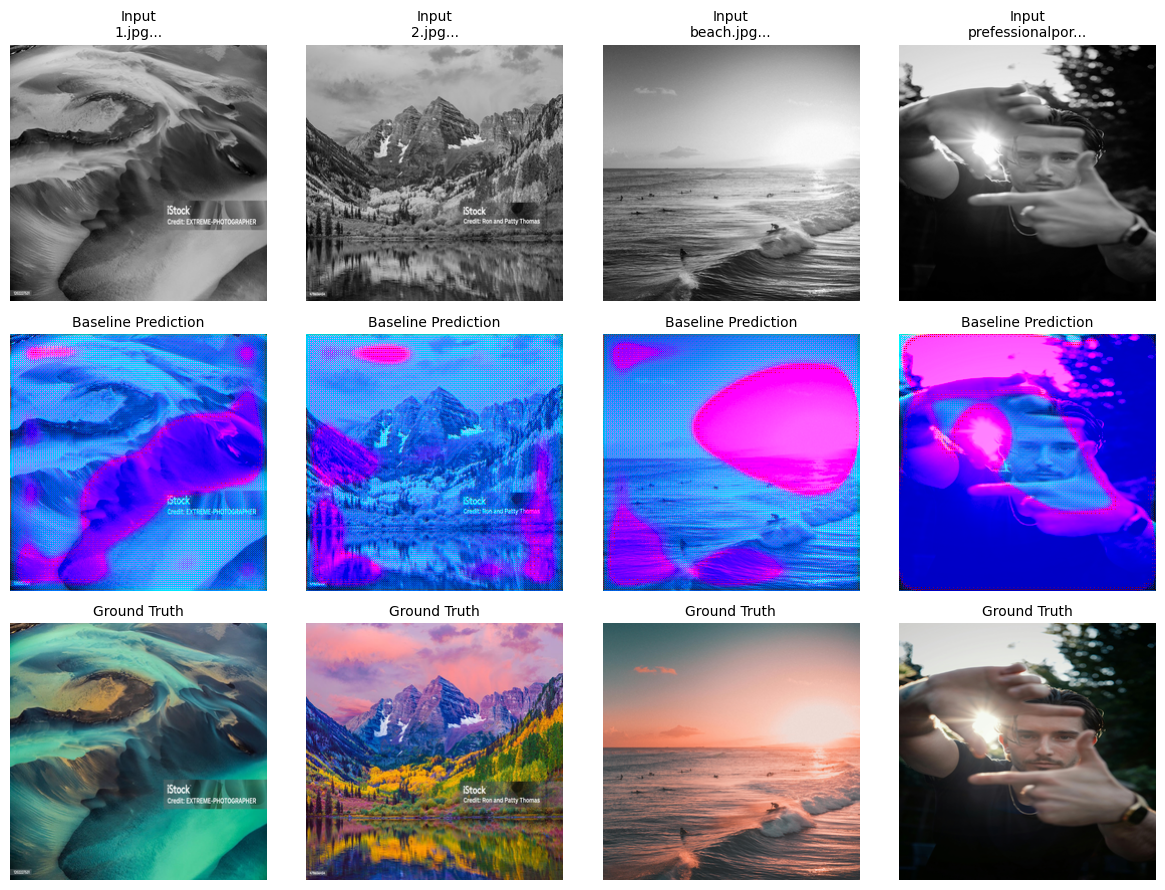

✓ Sample results saved to: ../results/baseline\sample_results.png


In [11]:
# Generate sample colorization results
if 'model' in locals() and 'val_loader' in locals():
    print("Generating sample colorization results...")
    
    try:
        # Get a few sample images
        model.eval()
        sample_results = []
        
        with torch.no_grad():
            for batch_idx, (L, AB, filenames) in enumerate(val_loader):
                if batch_idx >= 2:  # Only take first 2 batches
                    break
                
                # Get model predictions
                L_gpu = L.to(device)
                AB_pred = model(L_gpu).cpu()
                
                # Convert to RGB for visualization
                pred_rgb = evaluator.lab_to_rgb(L, AB_pred)
                target_rgb = evaluator.lab_to_rgb(L, AB)
                
                # Store results
                for i in range(min(4, len(filenames))):
                    sample_results.append({
                        'filename': filenames[i],
                        'input_L': L[i, 0].numpy(),
                        'prediction': pred_rgb[i],
                        'target': target_rgb[i]
                    })
        
        # Create visualization
        if sample_results:
            num_samples = min(6, len(sample_results))
            fig, axes = plt.subplots(3, num_samples, figsize=(3*num_samples, 9))
            
            if num_samples == 1:
                axes = axes.reshape(3, 1)
            
            for i in range(num_samples):
                result = sample_results[i]
                
                # Denormalize L channel for display
                L_display = (result['input_L'] + 1) / 2  # -1,1 -> 0,1
                
                # Input (grayscale)
                axes[0, i].imshow(L_display, cmap='gray')
                axes[0, i].set_title(f'Input\n{result["filename"][:15]}...', fontsize=10)
                axes[0, i].axis('off')
                
                # Prediction
                axes[1, i].imshow(result['prediction'])
                axes[1, i].set_title('Baseline Prediction', fontsize=10)
                axes[1, i].axis('off')
                
                # Target
                axes[2, i].imshow(result['target'])
                axes[2, i].set_title('Ground Truth', fontsize=10)
                axes[2, i].axis('off')
            
            plt.tight_layout()
            
            # Save sample results
            samples_path = os.path.join(baseline_results_dir, 'sample_results.png')
            plt.savefig(samples_path, dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f"✓ Sample results saved to: {samples_path}")
        
        else:
            print("No sample results generated")
            
    except Exception as e:
        print(f"❌ Error generating sample results: {e}")
        
else:
    print("Model or data not available for generating sample results")

## Summary and Next Steps

In [12]:
# Print comprehensive summary
print("BASELINE TRAINING SUMMARY")
print("=" * 50)

if 'history' in locals():
    print(f"✅ Training Status: COMPLETED")
    print(f"📊 Final Validation Loss: {history['best_val_loss']:.4f}")
    print(f"⏱️  Training Duration: {training_duration/60:.1f} minutes")
    print(f"🔢 Model Parameters: {model.count_parameters():,}")
    print(f"💾 Model Size: {model.get_model_size():.2f} MB")
    
    if 'avg_metrics' in locals():
        print(f"\n📈 Quick Evaluation Metrics:")
        print(f"   PSNR: {avg_metrics['psnr']:.2f} dB")
        print(f"   SSIM: {avg_metrics['ssim']:.4f}")
    
else:
    print("❌ Training Status: NOT COMPLETED")

print(f"\n📁 Files Generated:")
generated_files = [
    f"models/baseline_model/baseline_model_complete.pth",
    f"models/baseline_model/baseline_weights.pth",
    f"models/baseline_model/model_info.yaml",
    f"results/baseline/training_history.yaml",
    f"results/baseline/training_curves.png",
    f"results/baseline/quick_evaluation.yaml",
    f"results/baseline/sample_results.png"
]

for file in generated_files:
    if os.path.exists(f"../{file}"):
        print(f"   ✅ {file}")
    else:
        print(f"   ❌ {file} (not created)")

print(f"\n🎯 Next Steps:")
print(f"1. ✅ Baseline model training completed")
print(f"2. 📝 Run notebook 05_model_training_augmented.ipynb to train with augmentation")
print(f"3. 📊 Run notebook 06_evaluation_comparison.ipynb to compare baseline vs augmented")
print(f"4. 🖥️  Use notebook 07_gui_demo.ipynb to test the trained model interactively")

print(f"\n💡 Key Observations:")
if 'history' in locals():
    final_gap = history['val_losses'][-1] - history['train_losses'][-1]
    if final_gap > 0.01:
        print(f"   ⚠️  Model shows signs of overfitting (val loss > train loss)")
        print(f"   🔧 Data augmentation should help improve generalization")
    else:
        print(f"   ✅ Model shows good train-validation balance")
        print(f"   📈 Augmentation may still improve performance on diverse data")
        
    if 'avg_metrics' in locals() and avg_metrics['psnr'] < 20:
        print(f"   📊 PSNR could be improved - try different architectures or longer training")
else:
    print(f"   ❌ Complete the training first to get observations")
    
print(f"\n🏁 Baseline training phase complete! Ready for augmentation experiments.")

BASELINE TRAINING SUMMARY
✅ Training Status: COMPLETED
📊 Final Validation Loss: 0.4998
⏱️  Training Duration: 17.9 minutes
🔢 Model Parameters: 31,036,546
💾 Model Size: 118.44 MB

📈 Quick Evaluation Metrics:
   PSNR: 7.16 dB
   SSIM: 0.6881

📁 Files Generated:
   ✅ models/baseline_model/baseline_model_complete.pth
   ✅ models/baseline_model/baseline_weights.pth
   ✅ models/baseline_model/model_info.yaml
   ✅ results/baseline/training_history.yaml
   ✅ results/baseline/training_curves.png
   ✅ results/baseline/quick_evaluation.yaml
   ✅ results/baseline/sample_results.png

🎯 Next Steps:
1. ✅ Baseline model training completed
2. 📝 Run notebook 05_model_training_augmented.ipynb to train with augmentation
3. 📊 Run notebook 06_evaluation_comparison.ipynb to compare baseline vs augmented
4. 🖥️  Use notebook 07_gui_demo.ipynb to test the trained model interactively

💡 Key Observations:
   ⚠️  Model shows signs of overfitting (val loss > train loss)
   🔧 Data augmentation should help improve ge